<a href="https://colab.research.google.com/github/BorisAbramovich/pose_estimation/blob/master/milestone2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from scipy.io import loadmat
from PIL import Image, ImageDraw
import numpy as np
import functools

In [2]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat
train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')

--2020-04-28 15:59:27--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  19.9MB/s    in 12s     

2020-04-28 15:59:39 (15.0 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2020-04-28 15:59:40--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  16.1MB/s    in 6.2s    

2020-04-28 15:59:47 (9.84 MB/s) - ‘test_32x32.mat’ saved [64275384/64

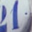

[1]


In [3]:
train['y'][train['y']==10]=0
test['y'][test['y']==10]=0
#for i in range(300):
#  im=train['X'][:,:,:,i]
#  img = Image.fromarray(im, 'RGB')
#  display(img)
#  print(train['y'][i])
i=1000
image = train['X'][:,:,:,i]
display(Image.fromarray(image))
print(train['y'][i])

In [0]:
import torchvision
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
SVHN_dataset=torchvision.datasets.SVHN('.', split='train', transform=transform)
data_loader = DataLoader(SVHN_dataset, batch_size=512,
                        shuffle=True, num_workers=4)
SVHN_test_dataset=torchvision.datasets.SVHN('.', split='test', transform=transform)
test_data_loader = DataLoader(SVHN_test_dataset, batch_size=512,
                        shuffle=True, num_workers=4)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #convolution, kernel_size=5, channels=6, stride=1, padding=2
        self.conv1 = nn.Conv2d(3, 6, 5, stride=1, padding=2)
        #batch-normalization
        self.norm1 = nn.BatchNorm2d(6)
        #Max-pool, kernel_size=2, stride=2
        self.pool1 = nn.MaxPool2d(2, 2)
        #convolution, kernel_size=3, channels=12, stride=1, padding=1
        self.conv2 = nn.Conv2d(6, 12, 3, stride=1, padding=1)
        #batch-normalization
        self.norm2 = nn.BatchNorm2d(12)
        #Max-pool, kernel_size=2, stride=2
        self.pool2 = nn.MaxPool2d(2, 2)
        #convolution, kernel_size=3, channels=24, stride=1, padding=1
        self.conv3 = nn.Conv2d(12, 24, 3, stride=1, padding=1)
        #batch-normalization
        self.norm3 = nn.BatchNorm2d(24)
        #Max-pool, kernel_size=2, stride=2
        self.pool3 = nn.MaxPool2d(2, 2)
        #fully connected layer, output_size=10
        self.fc1 = nn.Linear(4 * 4 * 24, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.norm1(self.conv1(x))))
        #print("1",x.shape)
        x = self.pool2(F.relu(self.norm2(self.conv2(x))))
        #print('2', x.shape)
        x = self.pool3(F.relu(self.norm3(self.conv3(x))))
        #print('3', x.shape)
        x = x.view(-1, 24 * 4 * 4)
        x = self.fc1(x)
        #print('4', x.shape)
        return x


net = Net()
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=384, out_features=10, bias=True)
)

In [0]:
def get_accuracy(model, dataloader):

    model.eval()
    # TODO: calculate accuracy
    num_true = 0
    num_total = 0
    for data_batch, labels_batch in data_loader:
      res = model(data_batch)
      inferred = res.max(-1)[1]  #argmax torch style
      target = labels_batch
      num_true  += sum(map(lambda a,b: 1 if a==b else 0, inferred, target))
      num_total += len(target)
    
    accuracy = num_true/num_total
    model.train()
    return accuracy

In [0]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
pilTrans = transforms.ToPILImage()


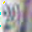

tensor(0)
0.06728367255006347


0.06728367255006347

In [144]:
dataiter = iter(data_loader)
images, labels = dataiter.next()
# show images
images[0].shape
pilImg = pilTrans(images[3])
display(pilImg)
print(labels[3])
# print labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
#get_accuracy(net, data_loader)

# Training

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [29]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0
#        if i % 200 == 199:
    print('acuracy:',get_accuracy(net, test_data_loader))
print('Finished Training')

[1,    50] loss: 0.297
[1,   100] loss: 0.277
acuracy: 0.9030672836725501
[2,    50] loss: 0.276
[2,   100] loss: 0.276
acuracy: 0.9166905551687893
[3,    50] loss: 0.268
[3,   100] loss: 0.279
acuracy: 0.9227923611395498
[4,    50] loss: 0.264
[4,   100] loss: 0.273
acuracy: 0.9224510968235118
[5,    50] loss: 0.265
[5,   100] loss: 0.272
acuracy: 0.9225193496867193
[6,    50] loss: 0.259
[6,   100] loss: 0.265
acuracy: 0.9237615517970978
[7,    50] loss: 0.267
[7,   100] loss: 0.270
acuracy: 0.9213317498669069
[8,    50] loss: 0.266
[8,   100] loss: 0.265
acuracy: 0.9219460256357754
[9,    50] loss: 0.270
[9,   100] loss: 0.260
acuracy: 0.9239663103867207
[10,    50] loss: 0.271
acuracy: 0.9228742645753989
[11,    50] loss: 0.267
[11,   100] loss: 0.276
acuracy: 0.9232974323272861
[12,    50] loss: 0.260
[12,   100] loss: 0.269
acuracy: 0.9201304994744529
[13,    50] loss: 0.261
[13,   100] loss: 0.271
acuracy: 0.914329006101806
[14,    50] loss: 0.268
[14,   100] loss: 0.264
acuracy

# Inference

In [0]:
def infer(image):
  return int(net(image[None,:,:]).max(-1)[1])

result:2 target:2


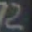

result:5 target:5


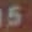

result:5 target:5


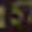

result:6 target:6


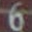

result:4 target:4


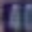

result:2 target:4


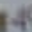

result:5 target:5


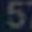

result:2 target:2


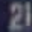

result:4 target:3


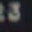

result:2 target:2


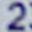

In [72]:
import random
SVHN_test_dataset=torchvision.datasets.SVHN('.', split='test', transform=transforms.ToTensor())

for i in range(10):
  idx = random.randint(0, len(SVHN_test_dataset))
  image, target = SVHN_test_dataset[idx]
  print('result:%d target:%d'%(infer(image), target))
  display(pilTrans(image))